<div style="float: right; margin: 0px 0px 0px 0px"><img src="images/clusters.png" width="400px"></div>

# Clustering: Picking the 'K' hyperparameter
The unsupervised machine learning technique of clustering data into similar groups can be useful and fairly efficient in most cases. The big trick is often how you pick the number of clusters to make (the K hyperparameter). 
The number of clusters may vary dramatically depending on the characteristics of the data, the different types of variables (numeric or categorical), how the data is normalized/encoded and the distance metric used.

<div style="float: left; margin: 20px 50px 20px 20px"><img src="images/picking.png" width="100px"></div>

**For this notebook we're going to focus specifically on the following:**
- Optimizing the number of clusters (K hyperparameter) using Silhouette Scoring
- Utilizing an algorithm (DBSCAN) that automatically determines the number of clusters


### Software
- Zeek Analysis Tools (ZAT): https://github.com/SuperCowPowers/zat
- Pandas: https://github.com/pandas-dev/pandas
- Scikit-Learn: http://scikit-learn.org/stable/index.html

<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/scikit.png" width="200px"></div>

### Techniques
- One Hot Encoding: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
- t-SNE: https://distill.pub/2016/misread-tsne/
- Kmeans: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- Silhouette Score: https://en.wikipedia.org/wiki/Silhouette_(clustering)
- DBSCAN: https://en.wikipedia.org/wiki/DBSCAN

In [1]:
# Third Party Imports
import pandas as pd
import numpy as np
import sklearn
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans, DBSCAN

# Local imports
import zat
from zat.log_to_dataframe import LogToDataFrame
from zat.dataframe_to_matrix import DataFrameToMatrix

# Good to print out versions of stuff
print('ZAT: {:s}'.format(zat.__version__))
print('Pandas: {:s}'.format(pd.__version__))
print('Scikit Learn Version:', sklearn.__version__)

ZAT: 0.4.4
Pandas: 1.0.4
Scikit Learn Version: 0.22.2.post1


In [3]:
# Create a Pandas dataframe from the Zeek log
log_to_df = LogToDataFrame()
http_df = log_to_df.create_dataframe('http.log')

# Print out the head of the dataframe
http_df.head()

,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,trans_depth,method,host,uri,referrer,...,info_msg,filename,tags,username,password,proxied,orig_fuids,orig_mime_types,resp_fuids,resp_mime_types
ts,,,,,,,,,,,,,,,,,,,,,
2013-09-15 23:44:27.668081999,CyIaMO7IheOh38Zsi,192.168.33.10,1031,54.245.228.191,80,1,GET,guyspy.com,/,NaN,...,NaN,NaN,(empty),NaN,NaN,NaN,NaN,NaN,Fnjq3r4R0VGmHVWiN5,text/html
2013-09-15 23:44:27.731701851,CoyZrY2g74UvMMgp4a,192.168.33.10,1032,54.245.228.191,80,1,GET,www.guyspy.com,/,NaN,...,NaN,NaN,(empty),NaN,NaN,NaN,NaN,NaN,FCQ5aX37YzsjAKpcv8,text/html
2013-09-15 23:44:28.092921972,CoyZrY2g74UvMMgp4a,192.168.33.10,1032,54.245.228.191,80,2,GET,www.guyspy.com,/wp-content/plugins/slider-pro/css/advanced-sl...,http://www.guyspy.com/,...,NaN,NaN,(empty),NaN,NaN,NaN,NaN,NaN,FD9Xu815Hwui3sniSf,text/html
2013-09-15 23:44:28.150300980,CiCKTz4e0fkYYazBS3,192.168.33.10,1040,54.245.228.191,80,1,GET,www.guyspy.com,/wp-content/plugins/contact-form-7/includes/cs...,http://www.guyspy.com/,...,NaN,NaN,(empty),NaN,NaN,NaN,NaN,NaN,FMZXWm1yCdsCAU3K9d,text/plain
2013-09-15 23:44:28.150601864,C1YBkC1uuO9bzndRvh,192.168.33.10,1041,54.245.228.191,80,1,GET,www.guyspy.com,/wp-content/plugins/slider-pro/css/slider/adva...,http://www.guyspy.com/,...,NaN,NaN,(empty),NaN,NaN,NaN,NaN,NaN,FA4NM039Rf9Y8Sn2Rh,text/plain


# Our HTTP features are a mix of numeric and categorical data
When we look at the http records some of the data is numerical and some of it is categorical so we'll need a way of handling both data types in a generalized way. We have a DataFrameToMatrix class that handles a lot of the details and mechanics of combining numerical and categorical data, we'll use below.

<div style="float: right; margin: 10px 40px 10px 40px"><img src="images/transformers.png" width="200px"></div>

## Transformers
**We'll now use the Scikit-Learn tranformer class to convert the Pandas DataFrame to a numpy ndarray (matrix). The transformer class takes care of many low-level details**
* Applies 'one-hot' encoding for the Categorical fields
* Normalizes the Numeric fields
* The class can be serialized for use in training and evaluation
  * The categorical mappings are saved during training and applied at evaluation
  * The normalized field ranges are stored during training and applied at evaluation

In [4]:
# We're going to pick some features that might be interesting
# some of the features are numerical and some are categorical
features = ['id.resp_p', 'method', 'resp_mime_types', 'request_body_len']

# Use the DataframeToMatrix class (handles categorical data)
# You can see below it uses a heuristic to detect category data. When doing
# this for real we should explicitly convert before sending to the transformer.
to_matrix = DataFrameToMatrix()
http_feature_matrix = to_matrix.fit_transform(http_df[features], normalize=True)

print('\nNOTE: The resulting numpy matrix has 12 dimensions based on one-hot encoding')
print(http_feature_matrix.shape)
http_feature_matrix[:1]

Normalizing column id.resp_p...
Normalizing column request_body_len...

NOTE: The resulting numpy matrix has 12 dimensions based on one-hot encoding
(150, 12)


array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [5]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12.0
plt.rcParams['figure.figsize'] = 14.0, 7.0

<div style="float: right; margin: 10px 40px 10px 40px"><img src="images/silhouette.jpg" width="150px"></div>

# Silhouette Scoring
"The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters."
- https://en.wikipedia.org/wiki/Silhouette_(clustering)

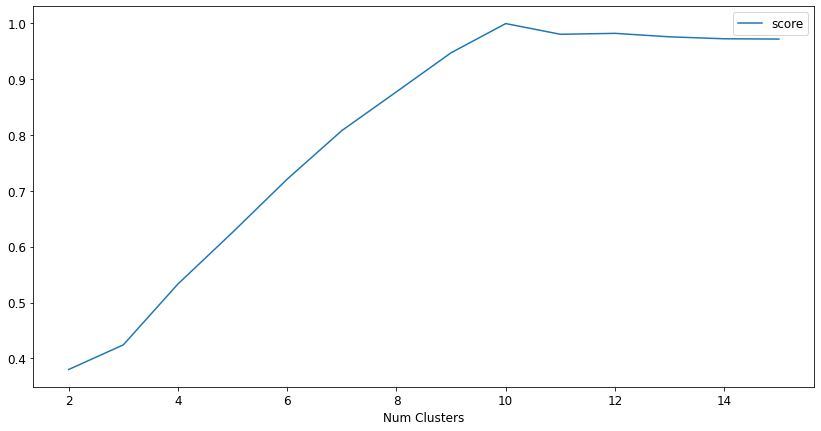

In [6]:
from sklearn.metrics import silhouette_score

scores = []
clusters = range(2,16)
for K in clusters:
    
    clusterer = KMeans(n_clusters=K)
    cluster_labels = clusterer.fit_predict(http_feature_matrix)
    score = silhouette_score(http_feature_matrix, cluster_labels)
    scores.append(score)

# Plot it out
pd.DataFrame({'Num Clusters':clusters, 'score':scores}).plot(x='Num Clusters', y='score')

## Silhouette graphs shows that 10 is the 'optimal' number of clusters
- 'Optimal': Human intuition and clustering involves interpretation/pattern finding and is often partially subjective :)
- For large datasets running an exhaustive search can be time consuming
- For large datasets you can often get a large K using max score, so pick the 'knee' of the graph as your K

In [7]:
# So we know that the highest (closest to 1) silhouette score is at 10 clusters
kmeans = KMeans(n_clusters=10).fit_predict(http_feature_matrix)

# TSNE is a great projection algorithm. In this case we're going from 12 dimensions to 2
projection = TSNE().fit_transform(http_feature_matrix)

# Now we can put our ML results back onto our dataframe!
http_df['cluster'] = kmeans
http_df['x'] = projection[:, 0] # Projection X Column
http_df['y'] = projection[:, 1] # Projection Y Column

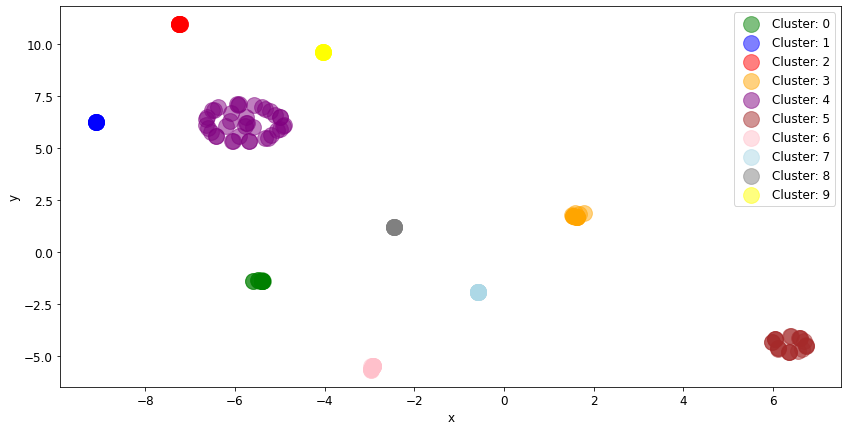

In [8]:
# Now use dataframe group by cluster
cluster_groups = http_df.groupby('cluster')

# Plot the Machine Learning results
colors = {-1:'black', 0:'green', 1:'blue', 2:'red', 3:'orange', 4:'purple', 5:'brown', 6:'pink', 7:'lightblue', 8:'grey', 9:'yellow'}
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='x', y='y', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

In [11]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head(3))


Cluster 0: 13 observations
                               id.resp_p method  resp_mime_types  request_body_len
ts                                                                                
2013-09-15 23:44:40.230550051         80    GET  application/pdf                 0
2013-09-15 23:44:40.230550051         80    GET  application/pdf                 0
2013-09-15 23:44:40.230550051         80    GET  application/pdf                 0

Cluster 1: 40 observations
                               id.resp_p method resp_mime_types  request_body_len
ts                                                                               
2013-09-15 23:44:28.150300980         80    GET      text/plain                 0
2013-09-15 23:44:28.150601864         80    GET      text/plain                 0
2013-09-15 23:44:28.192918062         80    GET      text/plain                 0

Cluster 2: 22 observations
                               id.resp_p method resp_mime_types  request_body_len
ts       

<div style="float: right; margin: 30px 20px 20px 20px"><img src="images/no_hands.jpg" width="250px"></div>

# Look Ma... No K!

### DBSCAN
Density-based spatial clustering is a data clustering algorithm that given a set of points in space, groups points that are closely packed together and marking low-density regions as outliers.

- You don't have to pick K
- There are other hyperparameters (eps and min_samples) but defaults often work well
- https://en.wikipedia.org/wiki/DBSCAN
- Hierarchical version: https://github.com/scikit-learn-contrib/hdbscan

In [9]:
# Now try DBScan
http_df['cluster_db'] = DBSCAN().fit_predict(http_feature_matrix)
print('Number of Clusters: {:d}'.format(http_df['cluster_db'].nunique()))

Number of Clusters: 10


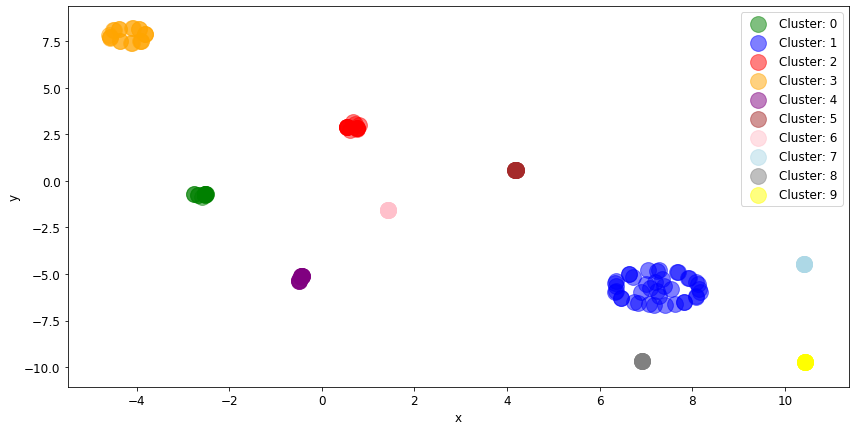

In [13]:
# Now use dataframe group by cluster
cluster_groups = http_df.groupby('cluster_db')

# Plot the Machine Learning results
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='x', y='y', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/magic.jpg" width="300px"></div>

# DBSCAN automagically determined 10 clusters!
So obviously we got a bit lucky here and for different datasets with different feature distributions DBSCAN may not give you the optimal number of clusters right off the zat. There are two hyperparameters that can be tweeked but like we said the defaults often work well. See the DBSCAN and Hierarchical DBSCAN links for more information.

- https://en.wikipedia.org/wiki/DBSCAN
- Hierarchical version: https://github.com/scikit-learn-contrib/hdbscan


## Wrap Up
Well that's it for this notebook, given the usefulness and relatively efficiency of clustering it a good technique to include in your toolset. Understanding the K hyperparameter and how to determine optimal K (or not if you're using DBSCAN) is a good trick to know.

If you liked this notebook please visit the [zat](https://github.com/SuperCowPowers/zat) project for more notebooks and examples.